In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import f_oneway, kruskal
from scipy.stats import chi2_contingency
from statsmodels.graphics.gofplots import qqplot

In [2]:
df = pd.read_csv('./data/yulu_bike_sharing.txt')
df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


# **Problem Statement: Understand factors that affect e-bike demand and subsequent renting**

**Shape**

In [3]:
df.shape

(10886, 12)

**Information on dataframe**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


**Converting the dtype of datetime column**

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])

**Missing values**

In [6]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

# **Univariate Analysis**

## **Categorical columns**

In [7]:
cat_cols = ['season', 'holiday', 'workingday', 'weather']

**Printing the count of different categories for wach of the columns**

In [8]:
for col in cat_cols:
    print('Column:', col)
    print(df[col].value_counts())
    print('-'*50)

Column: season
4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64
--------------------------------------------------
Column: holiday
0    10575
1      311
Name: holiday, dtype: int64
--------------------------------------------------
Column: workingday
1    7412
0    3474
Name: workingday, dtype: int64
--------------------------------------------------
Column: weather
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
--------------------------------------------------


## **Continuous columns**

In [9]:
cont_cols = ['temp', 'atemp', 'humidity', 'windspeed']

In [10]:
df[cont_cols].describe()

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


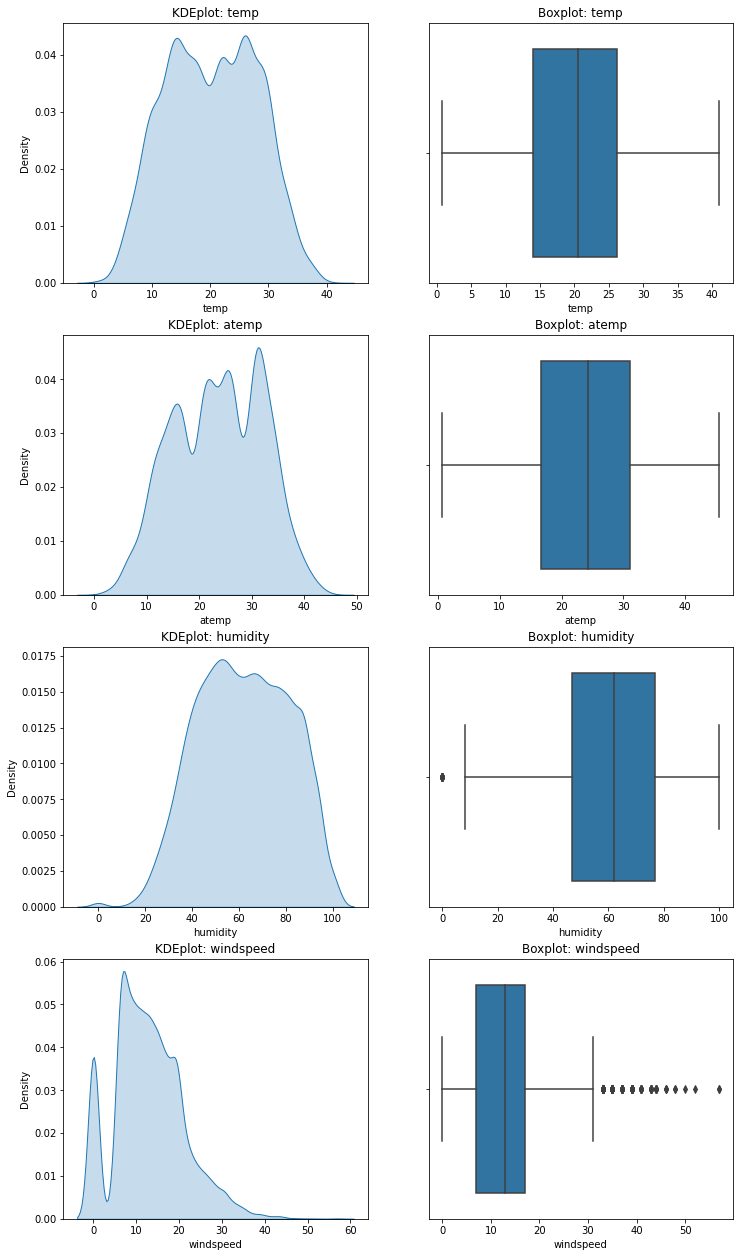

In [11]:
plt.figure(figsize=(12, 22))
i = 1
for col in cont_cols:
    plt.subplot(4,2,i)
    sns.kdeplot(x=df[col], fill=True)
    plt.title(f'KDEplot: {col}')
    plt.subplot(4,2,i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
    i += 2
plt.show()

**Observations:**
- Temperature does not have any outliers
- Humidity is also having very few ouliers
- Windspeed shows presence of many ouliers as shown by the boxplot

# **Bivariate analysis**

## **Number of rentals vs continuous variables**
- Temperature
- Feeling Temperature
- Humidity
- Windspeed

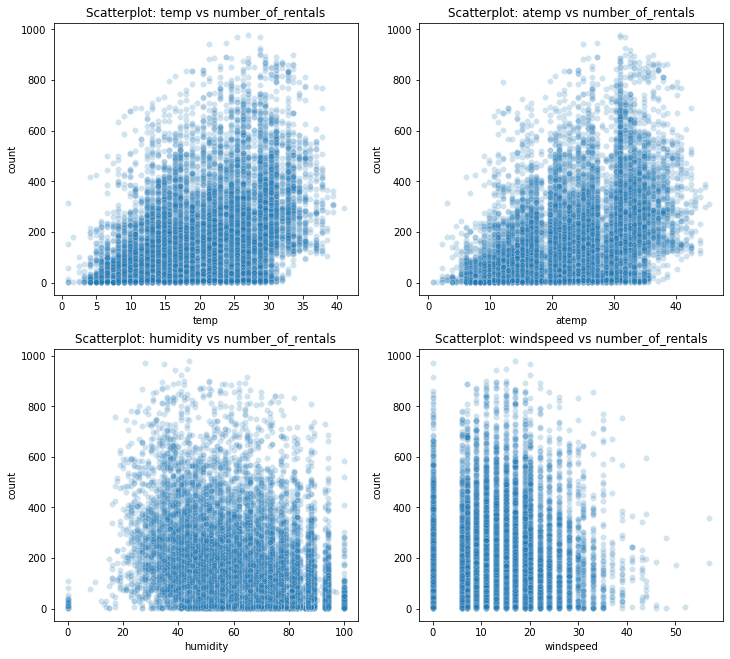

In [12]:
cont_cols = ['temp', 'atemp', 'humidity', 'windspeed']
plt.figure(figsize=(12, 11))
i = 1
for col in cont_cols:
    plt.subplot(2, 2, i)
    sns.scatterplot(x = df[col], y=df['count'], alpha=0.2)
    plt.title(f'Scatterplot: {col} vs number_of_rentals')
    i += 1
plt.show()

**Correlation matrix & heatmap:**

In [13]:
df[['atemp', 'humidity', 'windspeed', 'count']].corr()

,atemp,humidity,windspeed,count
atemp,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.057473,-0.318607,1.000000,0.101369
count,0.389784,-0.317371,0.101369,1.000000


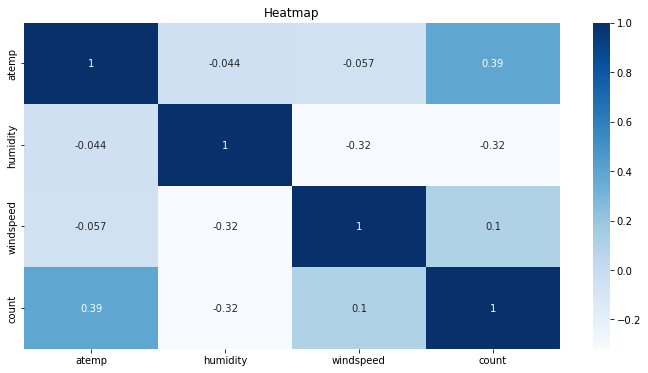

In [14]:
plt.figure(figsize=(12, 6))
sns.heatmap(df[['atemp', 'humidity', 'windspeed','count']].corr(), cmap='Blues', annot=True)
plt.title('Heatmap')
plt.show()

**Observations:**
- We see that Feeling temperature has a positive correlation (+0.4) with the number of bikes rented
- Humidity has a negative correlation (-0.3) with the number of bikes rented

## **Number of rentals vs continuous variables across Season & Weather**
- Feeling Temperature
- Humidity

In [15]:
def transform(x):
    if x == 1:
        return '1'
    elif x == 2:
        return '2'
    elif x == 3:
        return '3'
    return '4'

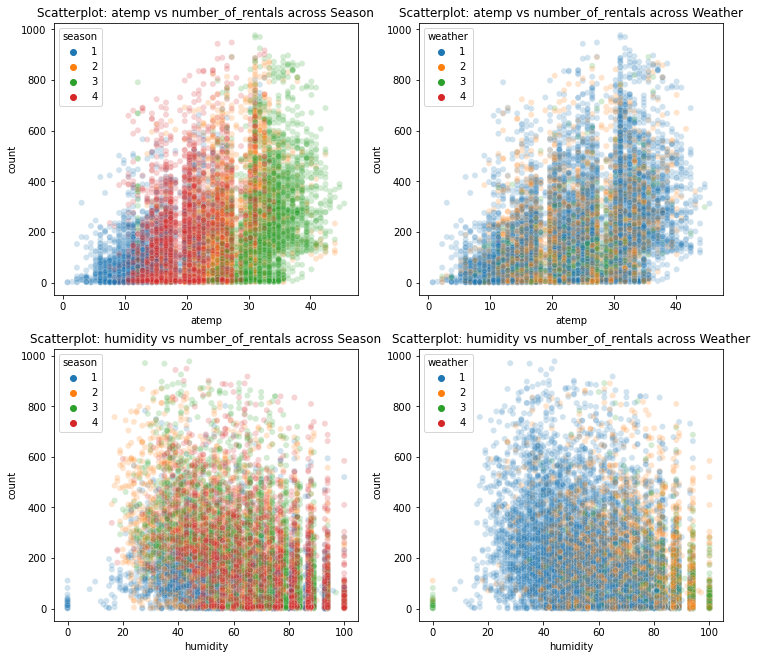

In [16]:
cont_cols_2 = ['atemp', 'humidity']
plt.figure(figsize=(12, 11))
i = 1
for col in cont_cols_2:
    plt.subplot(2, 2, i)
    sns.scatterplot(x = df[col], y=df['count'], hue=df['season'].apply(transform), alpha=0.2)
    plt.title(f'Scatterplot: {col} vs number_of_rentals across Season')
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x = df[col], y=df['count'], hue=df['weather'].apply(transform), alpha=0.2)
    plt.title(f'Scatterplot: {col} vs number_of_rentals across Weather')
    i += 2
plt.show()

**Observations:**
- Feeling Temperature vs number_of_rentals:
    - We do get a sense of the season-wise variation of the temperature
    - Also seasons 2 and 3 have data points where a high number of bikes were rented
    - When we see the data across weather, most of the data points seem to be blue (weather 1)
- Humidity vs number_of_rentals:
    - Season 4 seems to be the most humid season
    - Weather 1 seems to have lesser humidity than the other weathers

# **E-bike Rentals: Understanding the temporal impact**

## **Renting behaviour of users (Casual vs Registered)**

In [17]:
target_cols = ['casual', 'registered', 'count']
df[target_cols].describe()

,casual,registered,count
count,10886.000000,10886.000000,10886.000000
mean,36.021955,155.552177,191.574132
std,49.960477,151.039033,181.144454
min,0.000000,0.000000,1.000000
25%,4.000000,36.000000,42.000000
50%,17.000000,118.000000,145.000000
75%,49.000000,222.000000,284.000000
max,367.000000,886.000000,977.000000


In [18]:
total_count_casual_reg = [df['casual'].sum(), df['registered'].sum()]
total_count_casual_reg

[392135, 1693341]

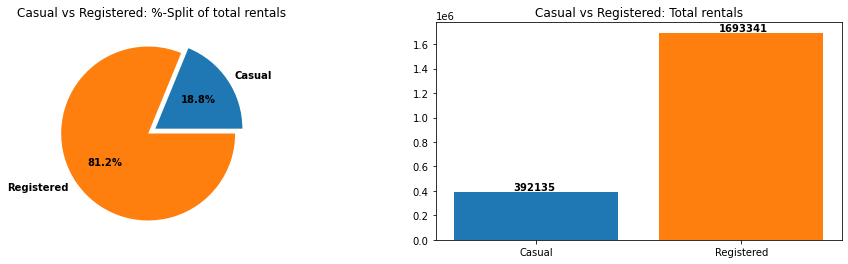

In [19]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.pie(total_count_casual_reg, labels=['Casual', 'Registered'], explode=(0.05, 0.05), 
        autopct='%.1f%%', textprops = {'fontweight': 'bold', 'fontsize': 10})
plt.title('Casual vs Registered: %-Split of total rentals')
plt.subplot(1, 2, 2)
plt.bar(x=['Casual', 'Registered'], height=total_count_casual_reg, color=['tab:blue', 'tab:orange'])
for i, data in enumerate(total_count_casual_reg):
    plt.text(x=i-0.11, y=data+10000, s=data, color='black', fontsize=10, fontweight='bold')
plt.title('Casual vs Registered: Total rentals')
plt.show()

**Observations:**
- The above plot shows the %-split b/w the casual and registered customers as far as the total number of booking asre concerned
- Casual rental activity amounts to ~20% of the total rental activity
- The bulk of rental activity (~80%) is done by registered customers

## **Hour wise rental trend**

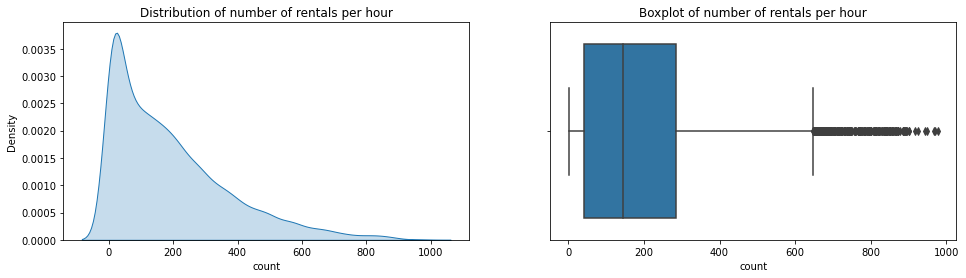

In [20]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(x=df['count'], fill=True)
# sns.histplot(x=df['count'])
plt.title('Distribution of number of rentals per hour')
plt.subplot(1, 2, 2)
sns.boxplot(x=df['count'])
plt.title('Boxplot of number of rentals per hour')
plt.show()

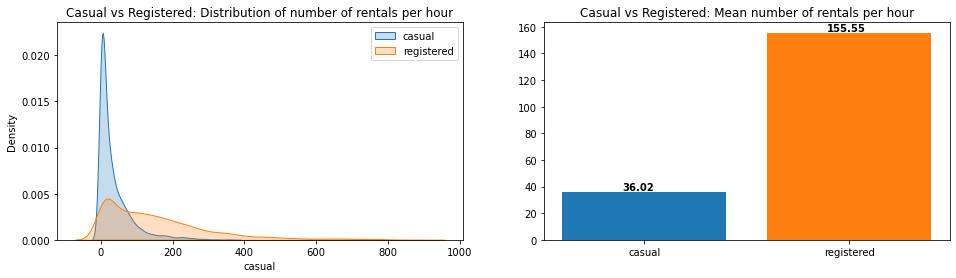

In [21]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
for col in ['casual', 'registered']:
    sns.kdeplot(x=df[col], fill=True, label=col)
plt.legend()
# sns.histplot(x=df_day_wise_count['count_sum'])
plt.title('Casual vs Registered: Distribution of number of rentals per hour')
plt.subplot(1, 2, 2)
plt.bar(x=['casual', 'registered'], height=[df['casual'].mean(), df['registered'].mean()], 
        color=['tab:blue', 'tab:orange'])
for i, data in enumerate([df['casual'].mean(), df['registered'].mean()]):
    plt.text(x=i-0.11, y=data+1, s=round(data,2), color='black', fontsize=10, fontweight='bold')
plt.title('Casual vs Registered: Mean number of rentals per hour')
plt.show()

**Observations:**
- The rental activity per hour shows a right skewed distribution for both casual and registered customers.
- The mean number of bikes rented by registered customers clearly outnumber that by casual customers

## **Day wise rental trend**

In [22]:
df_day_wise_count = df.groupby(df['datetime'].dt.date)[target_cols].agg(['sum'])
# df_day_wise_count.columns = [('_').join(lst) for lst in df_day_wise_count.columns]
df_day_wise_count.columns = [lst[0] for lst in df_day_wise_count.columns]
df_day_wise_count.reset_index(inplace=True)
df_day_wise_count['datetime'] = pd.to_datetime(df_day_wise_count['datetime'])
df_day_wise_count.head()

,datetime,casual,registered,count
0,2011-01-01,331,654,985
1,2011-01-02,131,670,801
2,2011-01-03,120,1229,1349
3,2011-01-04,108,1454,1562
4,2011-01-05,82,1518,1600


In [23]:
df_day_wise_count['year'] = df_day_wise_count['datetime'].dt.year
df_day_wise_count['month'] = df_day_wise_count['datetime'].dt.month
# df_day_wise_count.groupby(['year', 'month'])['count'].agg(['count'])

In [24]:
df_day_wise_count.describe()

,casual,registered,count,year,month
count,456.000000,456.000000,456.000000,456.000000,456.000000
mean,859.945175,3713.467105,4573.412281,2011.500000,6.500000
std,698.913571,1494.477105,1868.740135,0.500549,3.455844
min,9.000000,491.000000,605.000000,2011.000000,1.000000
25%,318.000000,2696.000000,3305.500000,2011.000000,3.750000
50%,722.000000,3700.000000,4585.500000,2011.500000,6.500000
75%,1141.750000,4814.250000,5987.500000,2012.000000,9.250000
max,3410.000000,6911.000000,8714.000000,2012.000000,12.000000


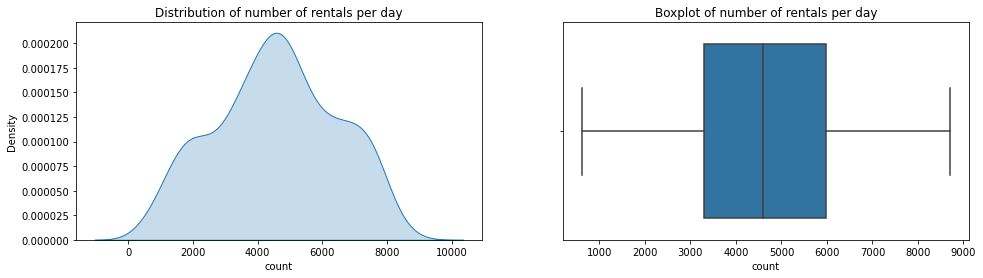

In [25]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(x=df_day_wise_count['count'], fill=True)
# sns.histplot(x=df_day_wise_count['count_sum'])
plt.title('Distribution of number of rentals per day')
plt.subplot(1, 2, 2)
sns.boxplot(x=df_day_wise_count['count'])
plt.title('Boxplot of number of rentals per day')
plt.show()

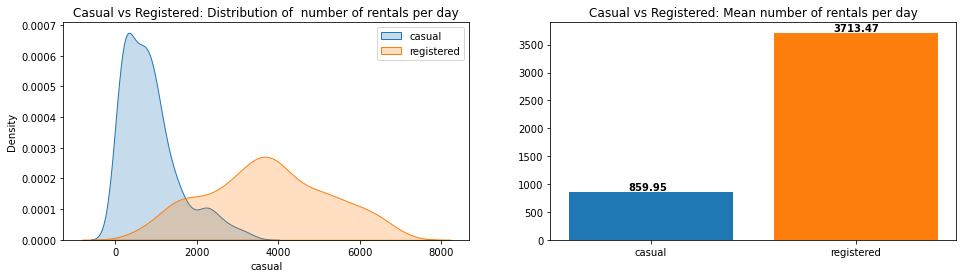

In [26]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
for col in ['casual', 'registered']:
    sns.kdeplot(x=df_day_wise_count[col], fill=True, label=col)
plt.legend()
# sns.histplot(x=df_day_wise_count['count_sum'])
plt.title('Casual vs Registered: Distribution of  number of rentals per day')
plt.subplot(1, 2, 2)
plt.bar(x=['casual', 'registered'], height=[df_day_wise_count['casual'].mean(), df_day_wise_count['registered'].mean()], 
        color=['tab:blue', 'tab:orange'])
for i, data in enumerate([df_day_wise_count['casual'].mean(), df_day_wise_count['registered'].mean()]):
    plt.text(x=i-0.11, y=data+30, s=round(data,2), color='black', fontsize=10, fontweight='bold')
plt.title('Casual vs Registered: Mean number of rentals per day')
plt.show()

**Observations:**
- The number of bikes rented per day is shown above.
- Clearly the mean of renting done by registered customers outnumber that by casual customers
- Also as evident from the kdeplot:
    - The max renting done by casual customers happend somewhere around 4000 per day
    - However for registered customers, this number reachs close to 8000 per day

## **Slot wise rental trend**

In [27]:
df_time_slot = df.copy()
df_time_slot['time'] = df_time_slot['datetime'].dt.time
df_time_slot['time'] = df_time_slot['time'].apply(lambda x: int(str(x).split(':')[0]))
bins_ts = [-1, 2, 8, 14, 20, 24]
label_ts = ['Night_9PM-2AM', 'Morning_3AM-8AM', 'Day_9AM-2PM', 'Evening_3PM-8PM', 'Night_9PM-2AM']
df_time_slot['time_slot'] = pd.cut(df_time_slot['time'], bins = bins_ts, labels = label_ts, ordered=False)
df_time_slot.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time,time_slot
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,Night_9PM-2AM
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,Night_9PM-2AM
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,Night_9PM-2AM
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,Morning_3AM-8AM
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,Morning_3AM-8AM


In [28]:
df_slot_wise_mean = df_time_slot.groupby('time_slot')[target_cols].agg(['mean'])
df_slot_wise_mean.columns = [lst[0] for lst in df_slot_wise_mean.columns]
df_slot_wise_mean.reset_index(inplace=True)
df_slot_wise_mean = df_slot_wise_mean.sort_values(by='count')
df_slot_wise_mean[target_cols] = df_slot_wise_mean[target_cols]*6
df_slot_wise_mean
# list(df_slot_wise_mean['time_slot'])

,time_slot,casual,registered,count
3,Night_9PM-2AM,88.498349,421.233028,509.731376
2,Morning_3AM-8AM,42.421248,656.502972,698.924220
0,Day_9AM-2PM,356.698134,1008.753019,1365.451153
1,Evening_3PM-8PM,373.756579,1640.335526,2014.092105


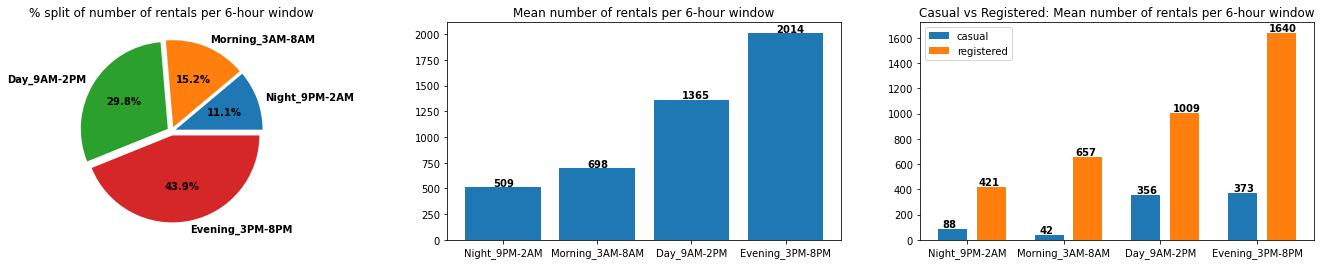

In [29]:
plt.figure(figsize=(24, 4))
plt.subplot(1, 3, 1)
plt.pie(df_slot_wise_mean['count'], labels=list(df_slot_wise_mean['time_slot']), explode=(0.05, 0.05, 0.05, 0.05), 
        autopct='%.1f%%', textprops = {'fontweight': 'bold', 'fontsize': 10})
plt.title('% split of number of rentals per 6-hour window')
plt.subplot(1, 3, 2)
plt.bar(x=df_slot_wise_mean['time_slot'], height=df_slot_wise_mean['count'])
for ind,data in enumerate(df_slot_wise_mean['count']):
    plt.text(x=ind-0.1, y=data+10, s=f'{int(data)}', color='black', fontsize=10, fontweight='bold', rotation=0)
plt.title('Mean number of rentals per 6-hour window')
plt.subplot(1, 3, 3)
index = np.arange(4)
width = 0.3
plt.bar(x=index, height=df_slot_wise_mean['casual'], width=width, label='casual', color='tab:blue')
plt.bar(x=index+width+0.1, height=df_slot_wise_mean['registered'], width=width, label='registered', color='tab:orange')
for ind,data in enumerate(df_slot_wise_mean['casual']):
    plt.text(x=ind-0.1, y=data+12, s=f'{int(data)}', color='black', fontsize=10, fontweight='bold', rotation=0)
for ind,data in enumerate(df_slot_wise_mean['registered']):
    plt.text(x=ind+0.275, y=data+12, s=f'{int(round(data, 0))}', color='black', fontsize=10, fontweight='bold', rotation=0)
plt.xticks(ticks=index+(width/2), labels=list(df_slot_wise_mean['time_slot']))
plt.legend()
plt.title('Casual vs Registered: Mean number of rentals per 6-hour window')
plt.show()

**Observations:**
- 3PM-8PM is the time slot where the maximum number of rentals happen over the course of 24 hours
- The lowest renting activity happens during 9PM-2AM

## **Month wise rental trend**

In [30]:
df_month_wise_count = df_day_wise_count.groupby(['year', 'month'])[target_cols].agg(['sum'])
df_month_wise_count.columns = [lst[0] for lst in df_month_wise_count.columns]
df_month_wise_count.reset_index(inplace=True)
df_month_wise_count['year_mon'] = df_month_wise_count[['year', 'month']].apply(lambda x: str(x['year']) + str('_') + str(x['month']), axis=1)
df_month_wise_count.head()

,year,month,casual,registered,count,year_mon
0,2011,1,2008,21544,23552,2011_1
1,2011,2,3776,29068,32844,2011_2
2,2011,3,7910,30825,38735,2011_3
3,2011,4,12229,38288,50517,2011_4
4,2011,5,15865,63848,79713,2011_5


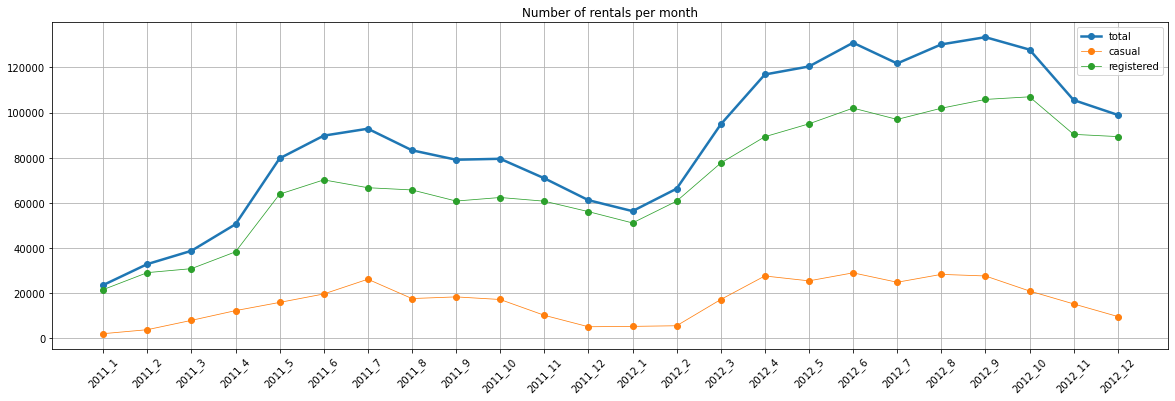

In [31]:
plt.figure(figsize=(20,6))
plt.plot(df_month_wise_count['year_mon'], df_month_wise_count['count'], marker='o', linewidth=2.5, label='total')
plt.plot(df_month_wise_count['year_mon'], df_month_wise_count['casual'], marker='o', linewidth=0.75, label='casual')
plt.plot(df_month_wise_count['year_mon'], df_month_wise_count['registered'], marker='o', linewidth=0.75, label='registered')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.title('Number of rentals per month')
plt.show()

**Observations:**
- We can see that total monthly rentals has been showing both upward and downward trends
- This is established since we can see prominent peaks and valleys in the trend
- The recently few months show a declining trend and is a casue of concern

# **E-bike Rentals: Understanding the impact of working day**

- The data we have is at the hour level
- We will aggregate and look at the data at the day level
- This is because the parameter 'working day' will not change across the hours for any given day

In [32]:
df_day_wise_workday_count = df.groupby(df['datetime'].dt.date)[['workingday', 'count']].agg(workingday=('workingday', 'mean'), count=('count', 'sum'))
df_day_wise_workday_0 = df_day_wise_workday_count.loc[df_day_wise_workday_count['workingday'] == 0, 'count']
df_day_wise_workday_1 = df_day_wise_workday_count.loc[df_day_wise_workday_count['workingday'] == 1, 'count']
print('Sample size:')
print('-'*50)
print('Workday_0:', df_day_wise_workday_0.size)
print('Workday_1:', df_day_wise_workday_1.size)

Sample size:
--------------------------------------------------
Workday_0: 145
Workday_1: 311


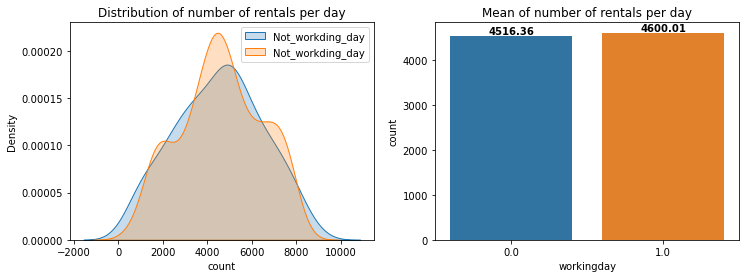

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(x=df_day_wise_workday_0, fill=True, label='Not_workding_day')
sns.kdeplot(x=df_day_wise_workday_1, fill=True, label='Not_workding_day')
plt.title('Distribution of number of rentals per day')
plt.legend()
plt.subplot(1, 2, 2)
f = sns.barplot(x=df_day_wise_workday_count['workingday'], y=df_day_wise_workday_count['count'], ci=None)
for i in f.containers:
    f.bar_label(i, fontsize=10, fontweight='bold')
plt.title('Mean of number of rentals per day')
plt.show()

## **Observations & Hypothesis formation:**

- We do see that the mean number of rentals vary across whether it is a working day or not. 
- We wish to find whether the imapct of working day on the renting of e-bikes is significant or not.
- Hence we propose the following:
    - ***H0: Working day does NOT impact the renting of e-bikes (u1=u2)***
        - That is working day & the renting of e-bikes are independent
    - ***H1: Working day does impact the renting of e-bikes (u1!=u2)***
        - That is working day & the renting of e-bikes are dependent)***
    - ***We propose to perform a ttest, setting significance level = 5%***

## **Levene's Test: For testing homogeneity of variance**

In [34]:
print('Standard deviations:')
print('-'*50)
print('Workday_0:', df_day_wise_workday_0.std())
print('Workday_1:', df_day_wise_workday_1.std())

Standard deviations:
--------------------------------------------------
Workday_0: 1956.3917349288931
Workday_1: 1829.0653138733692


In [35]:
# H0: Variance b/w the groups are equal
# H1: Variance b/w the groups are NOT equal
levene_stat, p_value = levene(df_day_wise_workday_0.values, df_day_wise_workday_1.values)
print('levene_stat:', round(levene_stat,2), 'p_value:', round(p_value,2))
print('-'*50)
if p_value < 0.05:
    print('Reject H0, accept H1')
else:
    print('Fail to reject H0')

levene_stat: 1.17 p_value: 0.28
--------------------------------------------------
Fail to reject H0


## **Assumptions for ttest:**

- ***The data has to be continuous in nature***
    - Comments:
        - The data we have (number of rentals per day) is indeed continuous in nature
- ***The sample has to random***
    - To obviate any bias
    - To be a true representation of the population
    - Comments:
        - We believe that the data we have is a truely ramdom sample
- ***Data has to be gaussian***
    - Either the original data is gaussian. In this case the sample size can be small (n < 30)
    - The original data is NOT gausiian. But sample size is sufficient. By CLT, the distribution of sample means will be gaussian
    - Comments:
        - The data we have is NOT gaussian, but thankfully we have a sufficiently large sample size (n = 145).
        - Thus by CLT, the distribution of sample means can be assuumed to be gaussian
- ***Homogeneity of variance b/w the two groups of data***
    - Comments:
        - Using levene's test we concluded that there is homogeneity of variance b/w the 2 groups (workday=0 & workday=1)
        - p_value = 0.28

## **Ttest:**

In [36]:
t_stat, p_value = ttest_ind(df_day_wise_workday_0, df_day_wise_workday_1)
print('t_stat:', round(t_stat,2), 'p_value:', round(p_value,2))
print('-'*50)
if p_value < 0.05:
    print('Reject H0, accept H1')
else:
    print('Fail to reject H0')

t_stat: -0.44 p_value: 0.66
--------------------------------------------------
Fail to reject H0


## **Conclusion:**
- ***Working day does NOT impact the renting of e-bikes significantly.***

# **E-bike Rentals: Understanding the seasonal impact**

- We want to look at the hourly renting of e-bikes
- We want to see if season has any significant impact on this parameter

In [37]:
season_1 = df.loc[df['season']==1, 'count']
season_2 = df.loc[df['season']==2, 'count']
season_3 = df.loc[df['season']==3, 'count']
season_4 = df.loc[df['season']==4, 'count']
print('Sample size:')
print('-'*50)
print('Season:1', season_1.size)
print('Season:2', season_2.size)
print('Season:3', season_3.size)
print('Season:4', season_4.size)

Sample size:
--------------------------------------------------
Season:1 2686
Season:2 2733
Season:3 2733
Season:4 2734


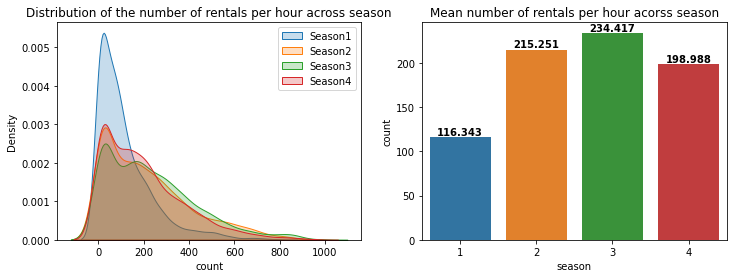

In [38]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(x=season_1, fill=True, label='Season1')
sns.kdeplot(x=season_2, fill=True, label='Season2')
sns.kdeplot(x=season_3, fill=True, label='Season3')
sns.kdeplot(x=season_4, fill=True, label='Season4')
plt.legend()
plt.title('Distribution of the number of rentals per hour across season')
plt.subplot(1, 2, 2)
f = sns.barplot(x=df['season'], y=df['count'], ci=None)
for i in f.containers:
    f.bar_label(i, fontsize=10, fontweight='bold')
plt.title('Mean number of rentals per hour acorss season')
plt.show()

## **Observations & Hypothesis formation:**
- We do see that the mean number of rentals vary across the seasons. 
- We wish to find whether the imapct of season on the renting of e-bikes is significant or not.
- Hence we propose the following:
    - ***H0: Season does NOT impact the renting of e-bikes (u1=u2=u3=u4)***
        - That is season & the renting of e-bikes are independent
    - ***H1: Season does impact the renting of e-bikes (ui!=uj for any (i,j) such that i!=j)***
        - That is season & the renting of e-bikes are dependent
    - ***We propose to perform ANNOVA, setting significance level = 5%***

## **Testing whether the data is normal or not?**

As evident from the below plots, the data is clearly not gaussian

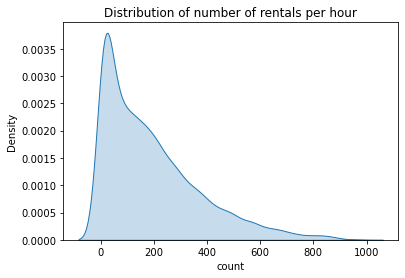

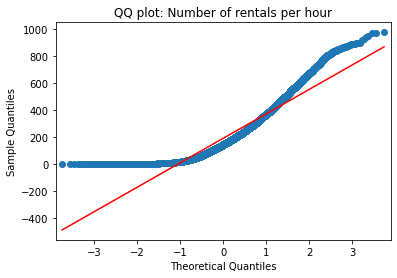

In [39]:
sns.kdeplot(x=df['count'], fill=True)
plt.title('Distribution of number of rentals per hour')
qqplot(df['count'], line="s")
plt.title('QQ plot: Number of rentals per hour')
plt.show()

## **Levene's Test: For testing homogeneity of variance**

In [40]:
print('Standard deviations:')
print('-'*50)
print('Season_1:', season_1.std())
print('Season_2:', season_2.std())
print('Season_3:', season_3.std())
print('Season_4:', season_4.std())

Standard deviations:
--------------------------------------------------
Season_1: 125.27397388810316
Season_2: 192.00784313546254
Season_3: 197.15100053680402
Season_4: 177.62240938763685


In [41]:
# H0: Variance b/w the groups are equal
# H1: Variance b/w the groups are NOT equal
levene_stat, p_value = levene(season_1, season_2, season_3, season_4)
print('levene_stat:', round(levene_stat,2), 'p_value:', round(p_value,2))
print('-'*50)
if p_value < 0.05:
    print('Reject H0, accept H1')
else:
    print('Fail to reject H0')

levene_stat: 187.77 p_value: 0.0
--------------------------------------------------
Reject H0, accept H1


## **Assumptions for ANNOVA:**

- ***Population is gaussian***
    - Comments:
        - The data we have does NOT meet this assumption
- ***Each sample is drawn independently of the other samples***
    - Comments:
        - - The data we have does meet this assumption
- ***Homogeneity of variance b/w the multiple groups in data***
    - Comments:
        - Using levene's test we concluded that there is NO homogeneity of variance b/w the multiple groups (season_1, season_2, season_3, season_4)
        - p_value = 0.0

## **Assumptions for ANNOVA failed, what next?**

- Since the assumptions for performing ANNOVA do not hold, we will perform Kruskal-Wallis test

## **Kruskal-Wallis Test:**

In [42]:
h_stat, p_value = kruskal(season_1, season_2, season_3, season_4)
print('h_stat:', round(h_stat,2), 'p_value:', round(p_value,2))
print('-'*50)
if p_value < 0.05:
    print('Reject H0, accept H1')
else:
    print('Fail to reject H0')

h_stat: 699.67 p_value: 0.0
--------------------------------------------------
Reject H0, accept H1


## **Conclusion**
- ***Season does impact the renting of e-bikes significantly.***

# **E-bike Rentals: Understanding the impact of weather**

- We want to look at the hourly renting of e-bikes
- We want to see if weather has any significant impact on this parameter

In [43]:
weather_1 = df.loc[df['weather']==1, 'count']
weather_2 = df.loc[df['weather']==2, 'count']
weather_3 = df.loc[df['weather']==3, 'count']
weather_4 = df.loc[df['weather']==4, 'count']
print('Sample size:')
print('-'*50)
print('Weather:1', weather_1.size)
print('Weather:2', weather_2.size)
print('Weather:3', weather_3.size)
print('Weather:4', weather_4.size)

Sample size:
--------------------------------------------------
Weather:1 7192
Weather:2 2834
Weather:3 859
Weather:4 1


**Ignoring the observation where weather=4**
- Since there is only one obseavation for weather=4, we do not consider it

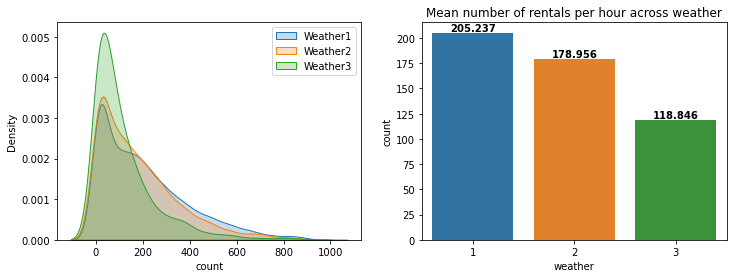

In [44]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(x=weather_1, fill=True, label='Weather1')
sns.kdeplot(x=weather_2, fill=True, label='Weather2')
sns.kdeplot(x=weather_3, fill=True, label='Weather3')
plt.legend()
plt.subplot(1, 2, 2)
f = sns.barplot(x=df.loc[df['weather']!=4, 'weather'], y=df.loc[df['weather']!=4, 'count'], ci=None)
for i in f.containers:
    f.bar_label(i, fontsize=10, fontweight='bold')
plt.title('Mean number of rentals per hour across weather')
plt.show()

## **Observations & Hypothesis formation:**
- We do see that the mean number of rentals vary across the weather. 
- We wish to find whether the imapct of weather on the renting of e-bikes is significant or not.
- Hence we propose the following:
    - ***H0: Weather does NOT impact the renting of e-bikes (u1=u2=u3)***
        - That is season & the renting of e-bikes are independent
    - ***H1: Weather does impact the renting of e-bikes (ui!=uj for any (i,j) such that i!=j)***
        - That is season & the renting of e-bikes are dependent
    - ***We propose to perform ANNOVA, setting significance level = 5%***

## **Levene's Test: For testing homogeneity of variance**

In [45]:
print('Standard deviations:')
print('-'*50)
print('Weather_1:', weather_1.std())
print('Weather_2:', weather_2.std())
print('Weather_3:', weather_3.std())

Standard deviations:
--------------------------------------------------
Weather_1: 187.9595660313148
Weather_2: 168.36641290145076
Weather_3: 138.58129705235916


In [46]:
# H0: Variance b/w the groups are equal
# H1: Variance b/w the groups are NOT equal
levene_stat, p_value = levene(weather_1, weather_2, weather_3)
print('levene_stat:', round(levene_stat,2), 'p_value:', round(p_value,2))
print('-'*50)
if p_value < 0.05:
    print('Reject H0, accept H1')
else:
    print('Fail to reject H0')

levene_stat: 81.68 p_value: 0.0
--------------------------------------------------
Reject H0, accept H1


## **Assumptions for ANNOVA:**

- ***Population is gaussian***
    - Comments:
        - The data we have does NOT meet this assumption
- ***Each sample is drawn independently of the other samples***
    - Comments:
        - - The data we have does meet this assumption
- ***Homogeneity of variance b/w the multiple groups in data***
    - Comments:
        - Using levene's test we concluded that there is NO homogeneity of variance b/w the multiple groups (weather_1, weather_2, weather_3)
        - p_value = 0.0

## **Kruskal-Wallis Test (assumptions of ANNOVA do not hold)**

In [47]:
h_stat, p_value = kruskal(weather_1, weather_2, weather_3)
print('h_stat:', round(h_stat,2), 'p_value:', round(p_value,2))
print('-'*50)
if p_value < 0.05:
    print('Reject H0, accept H1')
else:
    print('Fail to reject H0')

h_stat: 204.96 p_value: 0.0
--------------------------------------------------
Reject H0, accept H1


## **Conclusion**
- ***Weather does impact the renting of e-bikes significantly.***

# **Does weather depend on season?**

## **Contingency Table to see the hourly count of different weathers across different seasons**

In [48]:
season_weather = pd.crosstab(index=df['season'], columns=df['weather'], margins=True)
season_weather

weather,1,2,3,4,All
season,,,,,
1,1759,715,211,1,2686
2,1801,708,224,0,2733
3,1930,604,199,0,2733
4,1702,807,225,0,2734
All,7192,2834,859,1,10886


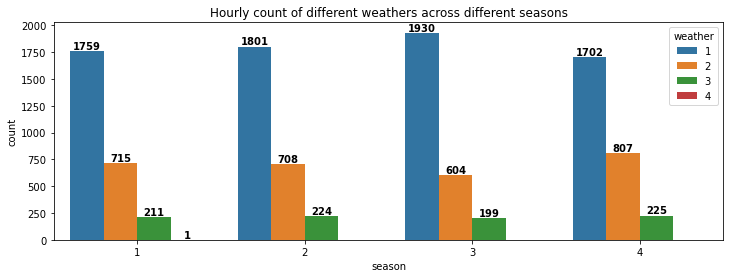

In [49]:
plt.figure(figsize=(12, 4))
f = sns.countplot(x=df['season'], hue=df['weather'])
for i in f.containers:
    f.bar_label(i, fontsize=10, fontweight='bold')
plt.title('Hourly count of different weathers across different seasons')
plt.show()

## **Observations & Hypothesis formation:**
- We wish to find whether waether is dependent on season.
- Hence we propose the following:
    - ***H0: Weather does NOT depend on season***
        - That is weather & season are independent
    - ***H1: Weather does depend on season***
        - That is weather & season are independent
    - ***We propose to perform Chi-Squared test, setting significance level = 5%***

## **Assumptions for Chi-Squared test:**

- ***The data has to be categorical in nature***
    - Comments:
        - The data we have meets this condition
- ***The observations are independent***
    - Comments:
        - The data we have meets this condition
- ***Each cell is mutually exclusive***
    - Comments:
        - The data we have meets this condition
- ***Expected value in each cell is greater than 5 (at least in 80% of the cells)***
    - Comments:
        - The data we have does NOT meet this condition
        - Since there is only one observation where weather = 4, we can do thsi experiment without that data point

In [50]:
season_weather_mod = pd.crosstab(index=df['season'], columns=df['weather'])
season_weather_mod = season_weather_mod.iloc[: , :3]
season_weather_mod

weather,1,2,3
season,,,
1,1759,715,211
2,1801,708,224
3,1930,604,199
4,1702,807,225


## **Chi-squared test**

In [51]:
chi_stat, p_value, dof, expected = chi2_contingency(season_weather_mod)
print('chi_stat:', chi_stat, 'p_value:', p_value)
print('-'*100)
if p_value < 0.05:
    print("Reject H0, Accept H1")
else:
    print("Fail to reject H0")

chi_stat: 46.10145731073249 p_value: 2.8260014509929343e-08
----------------------------------------------------------------------------------------------------
Reject H0, Accept H1


## **Conclusion**
- ***Weather does depend on seson significantly.***

# **Final Comments**

- The variables which have a significant impact on the rental activity of Yulu e-bikes are:
    - Season
    - Weather
    - We also found out that season and weather are significantly dependent on each other
- Further, The rental activity of Yulu e-bikes had a fair amount of correlation (>0.3) with the following variables:
    - Feeling temperature (positive correlation @ 0.4)
    - Humidity (Negative correlatiob @ -0.3)
- Registered users account for 80% of the total renting activity while the remaining 20% can be accounted to casual users
- The MoM trend of renting activity has shown periods of steady growth follwed by periods od steady decline.
    - We also observed that over the last few months the renting activity is on the decline
- Renting of these bikes happens all throughout the 24 hours. However we found out the following:
    - 3PM-8PM is the time slot where the maximum renting happens
    - 9PM-2AM is the time where the least renting happens